## Original code

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor
import shap
import joblib
import optuna


e:\Github\Modeling-the-design-capacity-of-social-infrastructure-facilities\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [31]:
# Загрузка данных и проверка на корректность столбцов
def load_geodata(file_path):
    """
    Загрузка геопространственных данных и очистка названий столбцов.
    """
    gdf = gpd.read_file(file_path)
    # gdf.to_crs('EPSG:3857', inplace=True)
    # Очистка названий столбцов (удаление лишних пробелов и скрытых символов)
    gdf.columns = gdf.columns.str.strip()

    # Проверка наличия столбца 'levels'
    if 'levels' not in gdf.columns:
        print("Столбец 'levels' отсутствует в данных. Создаем его со значением по умолчанию 0.")
        gdf['levels'] = 0  # или установите другое значение по умолчанию, если это необходимо

    # Приведение типа столбца 'levels' к целому числу
    gdf['levels'] = pd.to_numeric(gdf['levels'], errors='coerce').fillna(0).astype(int)
    return gdf

def compute_geometric_features(gdfs):
    """
    Вычисление геометрических характеристик, включая количество вершин.
    """
    gdf = gdfs[gdfs.geometry.type.isin(['Polygon', 'MultiPolygon'])].copy()
    # Вычисляем стандартные характеристики
    gdf['area'] = gdf['geometry'].area
    gdf['perimeter'] = gdf['geometry'].length
    gdf['compactness'] = (4 * np.pi * gdf['area']) / (gdf['perimeter'] ** 2)
    gdf['bounding_box'] = gdf['geometry'].apply(lambda x: x.minimum_rotated_rectangle)

    def calculate_length_and_width(polygon):
        coords = list(polygon.exterior.coords)
        side_lengths = [np.linalg.norm(np.array(coords[i]) - np.array(coords[i - 1])) for i in range(1, len(coords))]
        return max(side_lengths), min(side_lengths)

    gdf[['length', 'width']] = gdf['bounding_box'].apply(lambda x: pd.Series(calculate_length_and_width(x)))

    gdf['centroid_x'] = gdf['geometry'].centroid.x
    gdf['centroid_y'] = gdf['geometry'].centroid.y

    gdf['area_perimeter_ratio'] = gdf['area'] / gdf['perimeter']

    def count_vertices(geometry):
        if geometry.is_empty or geometry is None:
            return 0
        if geometry.type == 'Polygon':
            return len(geometry.exterior.coords)
        if geometry.type == 'MultiPolygon':
            return sum(len(polygon.exterior.coords) for polygon in geometry.geoms)
        return 0

    gdf['vertex_count'] = gdf.geometry.apply(count_vertices)
    gdf['convex_hull'] = gdf['geometry'].convex_hull
    gdf['convex_hull_area'] = gdf['convex_hull'].area
    gdf['convexity_ratio'] = gdf['area'] / gdf['convex_hull_area']
    gdf['centroid_distance_from_origin'] = np.sqrt(gdf['centroid_x']**2 + gdf['centroid_y']**2)

    return gdf.drop(columns=['bounding_box', 'convex_hull'])

def save_data(gdf, output_file_path):
    gdf.to_file(output_file_path, driver='GeoJSON')

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse, y_pred

def cross_validate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
    return np.sqrt(-scores).mean()

def plot_feature_importance(model, features):
    importances = model.feature_importances_
    plt.figure(figsize=(12, 8))
    sns.barplot(x=importances, y=features, palette="viridis", hue=None, legend=False)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

def optimize_xgboost_with_optuna(X_train, y_train):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
            'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1.0)
        }
        model = XGBRegressor(**params, random_state=42)
        score = cross_validate_model(model, X_train, y_train)
        return score

    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_params
    return XGBRegressor(**best_params, random_state=42)


In [32]:
file_path = 'data/input/school_spb.geojson'
schools_gdf = load_geodata(file_path)

schools_gdf = compute_geometric_features(schools_gdf)

features = ['area', 'perimeter', 'compactness', 'levels', 'length', 'width', 'area_perimeter_ratio', 'vertex_count', 'convexity_ratio']
X = schools_gdf[features]
y = schools_gdf['rgisCAPACITY']


E:\Temp\ipykernel_17332\45628570.py:46: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'Polygon':
E:\Temp\ipykernel_17332\45628570.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geometry.type == 'MultiPolygon':


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_xgboost = optimize_xgboost_with_optuna(X_train, y_train)
best_xgboost.fit(X_train, y_train)
rmse, y_pred = evaluate_model(best_xgboost, X_test, y_test)
print(f"Optimized XGBoost RMSE: {rmse}")

cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, random_state=42, verbose=0)
lgb_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05, max_depth=6, random_state=42)

cat_model.fit(X_train, y_train)
lgb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

ensemble_model = VotingRegressor(
    estimators=[('cat', cat_model), 
                ('lgb', lgb_model), 
                ('xgb', best_xgboost), 
                ('rf', rf_model), 
                ('gb', gb_model)]
                )

ensemble_model.fit(X_train, y_train)

ensemble_rmse, ensemble_y_pred = evaluate_model(ensemble_model, X_test, y_test)
print(f"Ensemble Model RMSE: {ensemble_rmse}")

# Сохранение лучшей модели
def save_model(model, file_name):
    joblib.dump(model, file_name)


E:\Temp\ipykernel_17332\4291709700.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis", hue=None, legend=False)


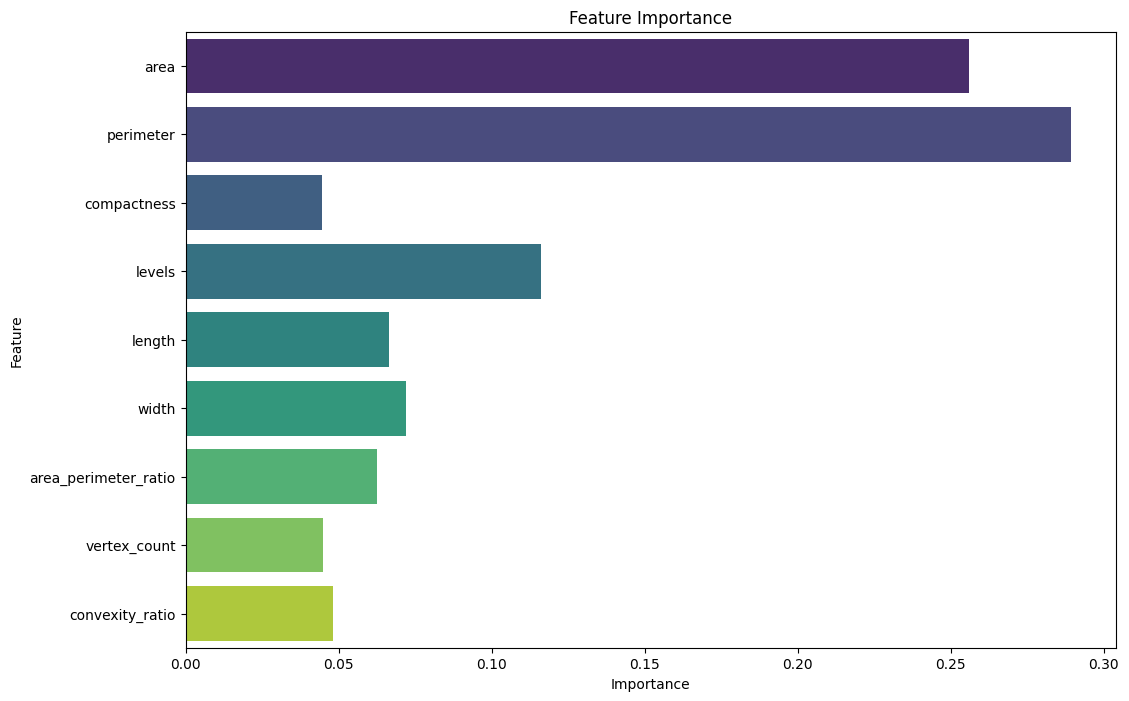

In [9]:
plot_feature_importance(best_xgboost, features)

## ITMO code


In [57]:
school_gdf = load_geodata('data/input/Школа, Санкт-Петербург.geojson')
school_gdf.to_crs(32636, inplace=True)
school_gdf = school_gdf[school_gdf['Вместимость реальная/прогнозная'] == 'прогнозная']

# school_gdf = compute_geometric_features(school_gdf)

Столбец 'levels' отсутствует в данных. Создаем его со значением по умолчанию 0.


<Axes: >

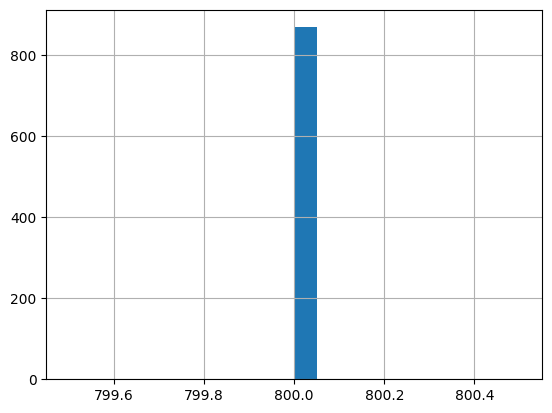

In [58]:
school_gdf['Вместимость'].hist(label='Реал', bins=20)

In [42]:
features = ['area', 'perimeter', 'compactness', 'levels', 'length', 'width', 'area_perimeter_ratio', 'vertex_count', 'convexity_ratio']
X = school_gdf[features]

school_gdf['capacity'] = np.round(ensemble_model.predict(X))

In [54]:
school_gdf.geometry.geom_type.unique()

array(['MultiPolygon', 'Polygon'], dtype=object)

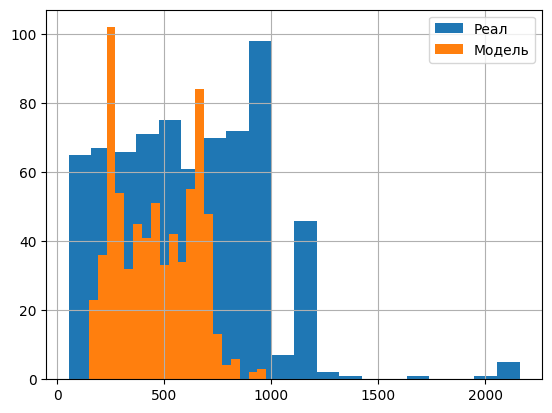

In [56]:
school_gdf['Вместимость'].hist(label='Реал', bins=20)
school_gdf['capacity'].hist(label='Модель', bins=20)
plt.legend()